In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
sns.set_style('darkgrid')
%matplotlib inline


In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('select name from sqlite_master where type ="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
cur.execute("""SELECT *
               FROM 'OrderDetail' """)

df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]

df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


**Null** : Giving a discount does not increase the sale quantity 
**Alternate** :  Giving a discount does increase the sale quantity


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2155 non-null   object 
 1   OrderId    2155 non-null   int64  
 2   ProductId  2155 non-null   int64  
 3   UnitPrice  2155 non-null   float64
 4   Quantity   2155 non-null   int64  
 5   Discount   2155 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [7]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [8]:
df[df.Discount > 0]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.40,35,0.15
7,10250/65,10250,65,16.80,15,0.15
8,10251/22,10251,22,16.80,6,0.05
9,10251/57,10251,57,15.60,15,0.05
11,10252/20,10252,20,64.80,40,0.05
...,...,...,...,...,...,...
2144,11077/39,11077,39,18.00,2,0.05
2146,11077/46,11077,46,12.00,3,0.02
2149,11077/60,11077,60,34.00,2,0.06
2150,11077/64,11077,64,33.25,2,0.03


In [12]:
df_discount = df[df.Discount > 0].reset_index()

In [13]:
df_no_discount = df[df.Discount == 0].reset_index()

In [15]:
print(len(df_discount))
len(df_no_discount)

838


1317

array([[<AxesSubplot:title={'center':'Quantity'}>]], dtype=object)

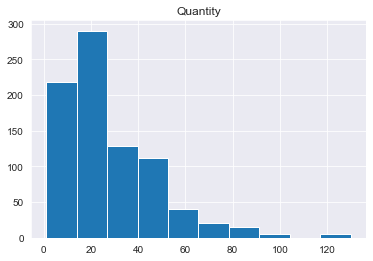

In [21]:
df_discount.hist(column = "Quantity")

In [41]:
df_discount["Quantity"].mean()

27.10978520286396

In [19]:
stats.shapiro(df_discount['Quantity'])

ShapiroResult(statistic=0.8690301179885864, pvalue=6.88120409395894e-26)

array([[<AxesSubplot:title={'center':'Quantity'}>]], dtype=object)

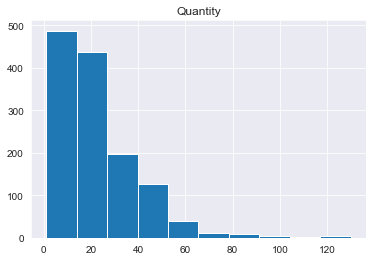

In [23]:
df_no_discount.hist("Quantity")

In [34]:
df_no_discount["Quantity"].mean()

21.715261958997722

In [24]:
stats.shapiro(df_no_discount['Quantity'])

ShapiroResult(statistic=0.8434571027755737, pvalue=3.803856556577728e-34)

In [28]:
def get_sample(data):
    import numpy as np
    sample = np.random.choice(data,30)
    return sample

In [62]:
def get_sample_mean(data):
    sample_means = []
    for i in range(6):
        sample_means.append(get_sample(data).mean())
    return sample_means

In [63]:
normal_sample_no_discount = get_sample_mean(df_no_discount["Quantity"])

In [64]:
np.mean(normal_sample_no_discount)
print(len(normal_sample_no_discount))

6


In [65]:
stats.shapiro(normal_sample_no_discount)

ShapiroResult(statistic=0.9275590777397156, pvalue=0.5613881349563599)

(array([2., 0., 0., 0., 1., 1., 0., 0., 1., 1.]),
 array([16.4       , 16.90666667, 17.41333333, 17.92      , 18.42666667,
        18.93333333, 19.44      , 19.94666667, 20.45333333, 20.96      ,
        21.46666667]),
 <BarContainer object of 10 artists>)

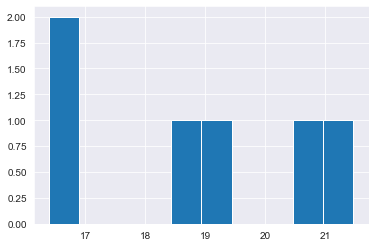

In [66]:
plt.hist(normal_sample_no_discount)

<AxesSubplot:ylabel='Density'>

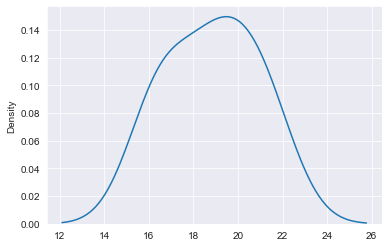

In [67]:
sns.kdeplot(normal_sample_no_discount)

In [68]:
normal_sample_discount = get_sample_mean(df_discount["Quantity"])

In [69]:
np.mean(normal_sample_discount)

27.349999999999998

In [72]:
stats.shapiro(normal_sample_discount)

ShapiroResult(statistic=0.929263710975647, pvalue=0.5744280815124512)

(array([1., 1., 1., 1., 0., 0., 0., 1., 0., 1.]),
 array([22.5       , 23.68333333, 24.86666667, 26.05      , 27.23333333,
        28.41666667, 29.6       , 30.78333333, 31.96666667, 33.15      ,
        34.33333333]),
 <BarContainer object of 10 artists>)

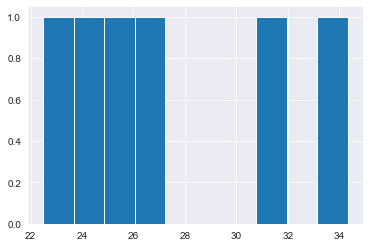

In [73]:
plt.hist(normal_sample_discount)

<AxesSubplot:ylabel='Density'>

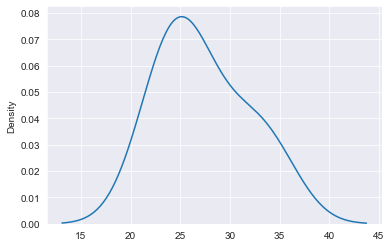

In [74]:
sns.kdeplot(normal_sample_discount)

In [75]:
stats.ttest_ind(normal_sample_discount, normal_sample_no_discount)

Ttest_indResult(statistic=4.230118922605225, pvalue=0.001743464638572072)

In [78]:
stats.ttest_ind(normal_sample_discount, normal_sample_no_discount, equal_var = False)

Ttest_indResult(statistic=4.230118922605224, pvalue=0.003884957463370567)

In [79]:
stats.ttest_ind(df_discount["Quantity"], df_no_discount["Quantity"])

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

In [80]:
stats.ttest_ind(df_discount["Quantity"], df_no_discount["Quantity"], equal_var= False)

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

In [81]:
def cohens_d(sample1,sample2):
    from numpy import std, mean, sqrt
    n1 = len(sample1)
    n2 = len(sample2)
    deg_freed = n1 + n2 - 2
    return abs(mean(sample1) - mean(sample2)) / sqrt(((n1 - 1) * std(sample1, ddof=1) **2 + (n2 - 1) * std(sample2, ddof=1) **2) / deg_freed)

In [82]:
cohens_d(normal_sample_discount, normal_sample_no_discount)

2.4422602986702566

In [83]:
power = TTestIndPower()

In [85]:
power.solve_power(effect_size= 1.80, nobs1= 6, alpha = 0.05)

0.8019236099197753

In [61]:
power.solve_power(effect_size= 1.8, power = 0.80, alpha = 0.05)

5.976650212211388

In [5]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
discount_rates = set(df.Discount.values)

In [11]:
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

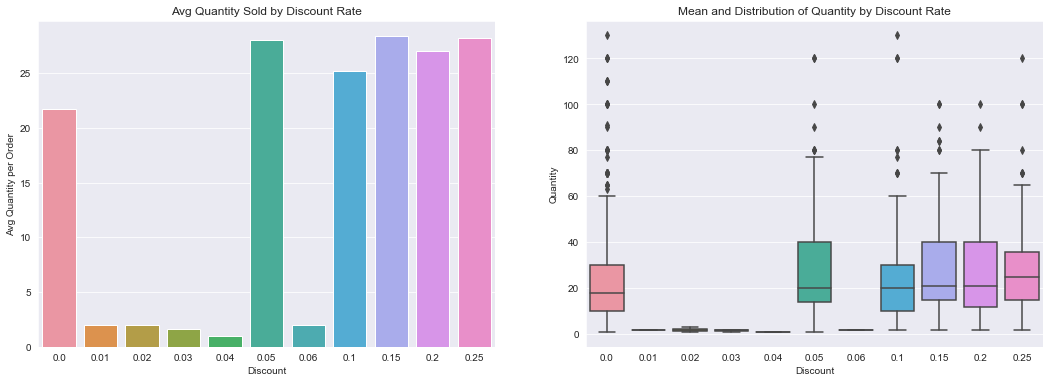

In [12]:
# set figure size and axes for two side-by-side plots
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

# plot the average quantity sold at each level of discount
a = sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
a.axes.set_title('Avg Quantity Sold by Discount Rate')
a.axes.set_xlabel('Discount')
a.axes.set_ylabel('Avg Quantity per Order')

# plot the mean and distribution of quantity sold at each discount level
b = sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
b.axes.set_title('Mean and Distribution of Quantity by Discount Rate')

plt.show()

In [13]:
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [86]:
d

array([ 35,  15,   6,  15,  40,  25,  15,  21,  50,  65,   6,  16,  15,
        21,  12,  60,  60,  36,  25,  12,  70,  15,  60,  20,  24,  15,
        60,  33,  12,   6,  15,  15,  20,   5,  45,  40,  36,  40,  15,
        10,   3,  20,  24,   2,  40,  30,  40,  30,  15,  25,  25,  30,
        40,  30,  25,  21,  70,  40,  80,  25,  50,  35,  30,  10,   8,
        20,  12,  50,  25,  40,  10,  16,  10,  40,   7,  25,   6,  48,
        18,  70,  20,  12,  40,   9,  24,  56,  40,  40,   4,  70,  36,
        50,   6,  15,  15,  18,  20,  77,  10,  20,  12,  50,  30,   8,
        10,  10,  20,  56,  70,  80,  54,  55,   5,  13,  35,  18,  15,
        20,   6,  12,  40,  70,  42,  80,  50,  42,  20,  20,   8,  16,
        20,  18,  20,   6,  10,  20,   8,  15,  20,  60,  40,  24,  25,
        42,   7,  70,  28,  70,  10,  18, 120,  21,  70,  30,  40,  30,
        30,  42,   5,   2,  25,  40,   9,  20,  18,   2,  36,  60,  20,
        20,   2,   8,  20,   4,  15,  10,  60,  49,  30,  10,  2

In [24]:
print("Size of no discount group: ", len(no_d))
print("Size of discount group: ", len(d))
print("Mean quantity of no discount group: ", round(no_d.mean(), 2))
print("Mean quantity of discount group: ", round(d.mean(), 2))
print("Standard deviation of no discount group: ", round(no_d.std(), 2))
print("Standard deviation of discount group: ", round(d.std(), 2))

Size of no discount group:  1317
Size of discount group:  838
Mean quantity of no discount group:  21.72
Mean quantity of discount group:  27.11
Standard deviation of no discount group:  17.5
Standard deviation of discount group:  20.76


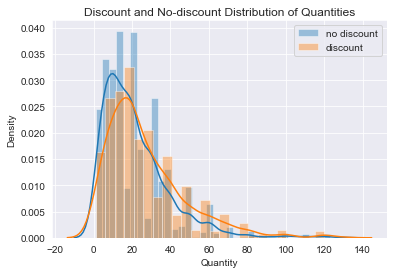

In [25]:
# plot two distribution plots together to compare
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()
plt.title('Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

In [26]:
alpha=.05

In [27]:
stats.shapiro(no_d)

(0.8434571027755737, 3.803856556577728e-34)

In [28]:
stats.shapiro(d)

(0.8690301179885864, 6.88120409395894e-26)

In [69]:
def get_sample(data):
    import numpy as np
    sample = np.random.choice(data,30)
    return sample

In [70]:
def get_sample_mean(data):
    sample_means = []
    for i in range(30):
        sample_means.append(get_sample(data).mean())
    return sample_means

In [71]:
no_discount_sample = get_sample_mean(no_d)

In [72]:
stats.shapiro(no_discount_sample)

(0.9558246731758118, 0.24140672385692596)

In [73]:
discount_sample = get_sample_mean(discount)

In [74]:
stats.shapiro(discount_sample)

(0.9624248147010803, 0.35674092173576355)

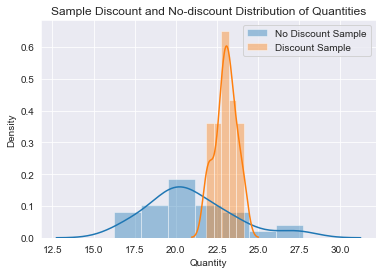

In [75]:
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()
plt.title('Sample Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');

In [76]:
stats.levene(no_discount_sample, discount_sample)

LeveneResult(statistic=17.58009006046259, pvalue=9.535029533948922e-05)

In [87]:
# run a independent t-test with unequal varance to determine p
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=False)[1]

In [79]:
p

0.00014416611813477097

In [81]:
def cohens_d(sample1,sample2):
    from numpy import std, mean, sqrt
    n1 = len(sample1)
    n2 = len(sample2)
    deg_freed = n1 + n2 - 2
    return abs(mean(sample1) - mean(sample2)) / sqrt(((n1 - 1) * std(sample1, ddof=1) **2 + (n2 - 1) * std(sample2, ddof=1) **2) / deg_freed)

In [88]:
discount_effect = cohens_d(no_discount_sample, discount_sample)
discount_effect

1.1114005567429248

In [85]:
power = TTestIndPower()
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.9954549483628078

In [90]:
power.solve_power(effect_size=discount_effect, power = 0.8, alpha=alpha, alternative='larger')

10.7565124607786